# 0. Khai báo schema

In [1]:
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType


borrower_profile_schema = StructType([
    StructField("member_id", IntegerType(), True),
    StructField("emp_title", StringType(), True),
    StructField("emp_length", StringType(), True),
    StructField("home_ownership", StringType(), True),
    StructField("annual_inc", DoubleType(), True),
    StructField("verification_status", StringType(), True),
    StructField("addr_state", StringType(), True),
    StructField("zip_code", StringType(), True)
])

loan_info_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("member_id", IntegerType(), True),
    StructField("loan_amnt", DoubleType(), True),
    StructField("funded_amnt", DoubleType(), True),
    StructField("funded_amnt_inv", DoubleType(), True),
    StructField("term", StringType(), True),
    StructField("int_rate", DoubleType(), True),
    StructField("installment", DoubleType(), True),
    StructField("grade", StringType(), True),
    StructField("sub_grade", StringType(), True),
    StructField("purpose", StringType(), True),
    StructField("title", StringType(), True),
    StructField("issue_d", StringType(), True),
    StructField("policy_code", DoubleType(), True),
    StructField("application_type", StringType(), True)
])

loan_status_history_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("loan_status", StringType(), True),
    StructField("pymnt_plan", StringType(), True),
    StructField("initial_list_status", StringType(), True),
    StructField("last_pymnt_d", StringType(), True),
    StructField("next_pymnt_d", StringType(), True),
    StructField("last_pymnt_amnt", DoubleType(), True),
    StructField("out_prncp", DoubleType(), True),
    StructField("out_prncp_inv", DoubleType(), True)
])

repayment_summary_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("total_pymnt", DoubleType(), True),
    StructField("total_pymnt_inv", DoubleType(), True),
    StructField("total_rec_prncp", DoubleType(), True),
    StructField("total_rec_int", DoubleType(), True),
    StructField("total_rec_late_fee", DoubleType(), True),
    StructField("recoveries", DoubleType(), True),
    StructField("collection_recovery_fee", DoubleType(), True)
])

credit_profile_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("member_id", IntegerType(), True),
    StructField("delinq_2yrs", DoubleType(), True),
    StructField("earliest_cr_line", StringType(), True),
    StructField("inq_last_6mths", DoubleType(), True),
    StructField("mths_since_last_delinq", DoubleType(), True),
    StructField("mths_since_last_record", DoubleType(), True),
    StructField("open_acc", DoubleType(), True),
    StructField("pub_rec", DoubleType(), True),
    StructField("revol_bal", DoubleType(), True),
    StructField("revol_util", DoubleType(), True),
    StructField("total_acc", DoubleType(), True),
    StructField("collections_12_mths_ex_med", DoubleType(), True),
    StructField("mths_since_last_major_derog", DoubleType(), True)
])

credit_account_detail_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("member_id", IntegerType(), True),
    StructField("open_acc_6m", DoubleType(), True),
    StructField("open_il_6m", DoubleType(), True),
    StructField("open_il_12m", DoubleType(), True),
    StructField("open_il_24m", DoubleType(), True),
    StructField("mths_since_rcnt_il", DoubleType(), True),
    StructField("total_bal_il", DoubleType(), True),
    StructField("il_util", DoubleType(), True),
    StructField("open_rv_12m", DoubleType(), True),
    StructField("open_rv_24m", DoubleType(), True),
    StructField("max_bal_bc", DoubleType(), True),
    StructField("all_util", DoubleType(), True),
    StructField("total_rev_hi_lim", DoubleType(), True),
    StructField("tot_coll_amt", DoubleType(), True),
    StructField("tot_cur_bal", DoubleType(), True),
    StructField("inq_fi", DoubleType(), True),
    StructField("total_cu_tl", DoubleType(), True),
    StructField("inq_last_12m", DoubleType(), True)
])

joint_application_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("annual_inc_joint", DoubleType(), True),
    StructField("dti_joint", DoubleType(), True),
    StructField("verification_status_joint", StringType(), True),
    StructField("acc_now_delinq", DoubleType(), True)
])

meta_reference_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("url", StringType(), True),
    StructField("desc", StringType(), True)
])

# 1. Borrower_profile: Hồ sơ người vay

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, mean, expr, when, round, isnan, desc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("EDA_BorrowerProfile") \
    .getOrCreate()

In [4]:
borrower_profile_df = (
    spark.read
    .option("header", True)
    .schema(borrower_profile_schema)
    .csv("hdfs://namenode:9000/bigdata/data/splitted_data/borrower_profile")
)
borrower_profile_df.printSchema()

root
 |-- member_id: integer (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- zip_code: string (nullable = true)



## Kiểm tra tỷ lệ missing values

In [ ]:
missing = (
    borrower_profile_df.select([ (count(when(col(c).isNull() | isnan(c), c)) / count("*")).alias(c) for c in borrower_profile_df.columns ])
    .collect()[0]
)
missing_df = pd.DataFrame(missing.asDict().items(), columns=['column', 'missing_ratio'])
missing_df['missing_ratio'] = (missing_df['missing_ratio'] * 100).round(2)
missing_df.sort_values('missing_ratio', ascending=False)

,column,missing_ratio
0,member_id,0.0
1,emp_title,0.0
2,emp_length,0.0
3,home_ownership,0.0
4,annual_inc,0.0
5,verification_status,0.0
6,addr_state,0.0
7,zip_code,0.0


## Thống kê mô tả cơ bản cho cột annual_inc

In [6]:
numeric_stats = borrower_profile_df.select("annual_inc").describe()
numeric_stats.show()

+-------+-----------------+
|summary|       annual_inc|
+-------+-----------------+
|  count|           886307|
|   mean|75019.61138585168|
| stddev|64691.84694335512|
|    min|              0.0|
|    max|        9500000.0|
+-------+-----------------+



## Thống kê phân bố theo các cột string

In [7]:
def freq_table(col_name, top_n=15):
    print(f"\n=== Frequency: {col_name} ===")
    borrower_profile_df.groupBy(col_name).count().orderBy(desc("count")).show(top_n, truncate=False)

for col_name in ["emp_title", "emp_length", "home_ownersbhip", "verification_status", "addr_state", "zip_code"]:
    if col_name in borrower_profile_df.columns:
        freq_table(col_name)


=== Frequency: emp_title ===
+----------------+-----+
|emp_title       |count|
+----------------+-----+
|Unknown         |51374|
|Teacher         |13795|
|Manager         |11631|
|Registered Nurse|5689 |
|Owner           |5508 |
|RN              |5485 |
|Supervisor      |5411 |
|Sales           |4454 |
|Project Manager |4085 |
|Driver          |3720 |
|Office Manager  |3614 |
|Director        |3326 |
|General Manager |3280 |
|manager         |3246 |
|teacher         |2976 |
+----------------+-----+
only showing top 15 rows


=== Frequency: emp_length ===
+-----------------------------+------+
|emp_length                   |count |
+-----------------------------+------+
|10+ years                    |291304|
|2 years                      |78763 |
|< 1 year                     |70434 |
|3 years                      |69938 |
|1 year                       |56987 |
|5 years                      |55646 |
|4 years                      |52461 |
|n/a                          |44795 |
|7 years 

## Tỷ lệ các giá trị unique ở 3 cột emp_length, home_ownership, verification_status

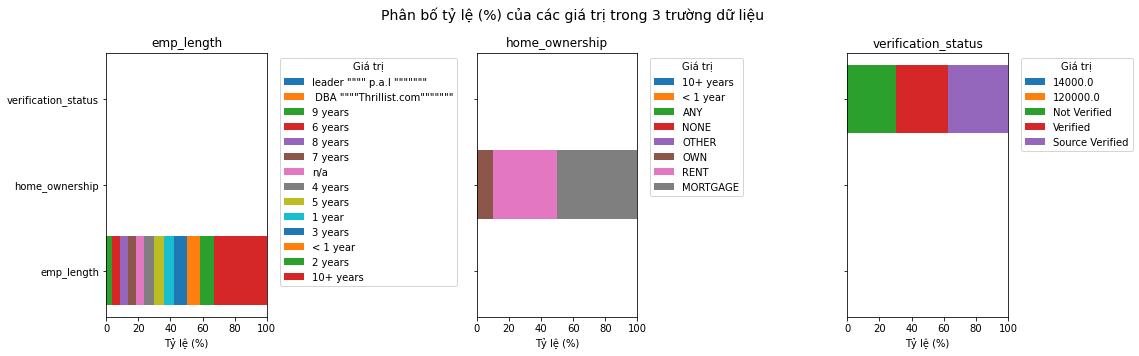

In [8]:
cols = ["emp_length", "home_ownership", "verification_status"]

total_rows = borrower_profile_df.count()

combined = pd.DataFrame()
for c in cols:
    temp = (
        borrower_profile_df.groupBy(c)
          .agg(count("*").alias("count"))
          .withColumn("pct", (col("count") / total_rows) * 100)
          .orderBy(col("pct").desc())
          .toPandas()
    )
    temp["column"] = c
    temp = temp.rename(columns={c: "value"})
    combined = pd.concat([combined, temp[["column", "value", "pct"]]], ignore_index=True)

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for i, c in enumerate(cols):
    borrower_profile_df_sub = combined[combined["column"] == c].copy()
    borrower_profile_df_sub = borrower_profile_df_sub.sort_values("pct", ascending=True)  # để thứ tự đẹp hơn

    left = 0
    for _, row in borrower_profile_df_sub.iterrows():
        axes[i].barh([c], row["pct"], left=left, label=row["value"])
        left += row["pct"]

    # Trang trí từng subplot
    axes[i].set_title(f"{c}")
    axes[i].set_xlim(0, 100)
    axes[i].set_xlabel("Tỷ lệ (%)")
    axes[i].set_ylabel("")
    axes[i].legend(title="Giá trị", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle("Phân bố tỷ lệ (%) của các giá trị trong 3 trường dữ liệu", fontsize=14)
plt.tight_layout()
plt.show()

## Trung bình thu nhập theo các nhóm

In [9]:
if "home_ownership" in borrower_profile_df.columns and "annual_inc" in borrower_profile_df.columns:
    avg_by_home = borrower_profile_df.groupBy("home_ownership").agg(round(mean("annual_inc"), 2).alias("avg_income"))
    print("\n=== Average income by home_ownership ===")
    avg_by_home.show()

if "verification_status" in borrower_profile_df.columns and "annual_inc" in borrower_profile_df.columns:
    avg_by_verif = borrower_profile_df.groupBy("verification_status").agg(round(mean("annual_inc"), 2).alias("avg_income"))
    print("\n=== Average income by verification_status ===")
    avg_by_verif.show()


=== Average income by home_ownership ===
+--------------+----------+
|home_ownership|avg_income|
+--------------+----------+
|           OWN|  68896.52|
|          RENT|  63976.72|
|      MORTGAGE|  85095.81|
|           ANY|  63726.67|
|         OTHER|  66892.75|
|          NONE|  61632.98|
|     10+ years|      null|
|      < 1 year|      null|
+--------------+----------+


=== Average income by verification_status ===
+-------------------+----------+
|verification_status|avg_income|
+-------------------+----------+
|           Verified|  78181.66|
|    Source Verified|  78904.35|
|       Not Verified|   66761.1|
|            14000.0|      null|
|           120000.0|      null|
+-------------------+----------+



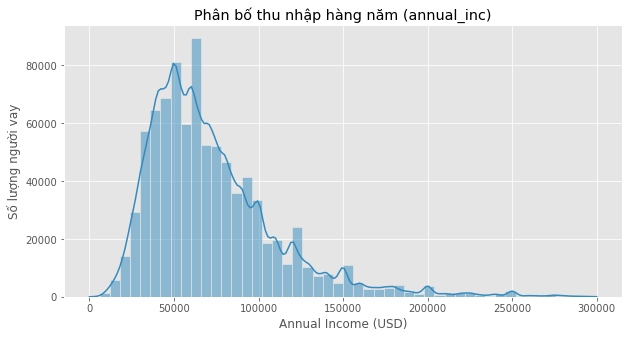

In [10]:
plt.style.use("ggplot")
income_pd = borrower_profile_df.select("annual_inc").dropna().toPandas()
income_pd = income_pd[income_pd["annual_inc"] < 300000]  # Giới hạn 300k USD

plt.figure(figsize=(10,5))
sns.histplot(income_pd["annual_inc"], bins=50, kde=True)
plt.title("Phân bố thu nhập hàng năm (annual_inc)")
plt.xlabel("Annual Income (USD)")
plt.ylabel("Số lượng người vay")
plt.show()

In [11]:
summary = borrower_profile_df.select(
    round(mean("annual_inc"), 2).alias("avg_income"),
    round(expr("percentile_approx(annual_inc, 0.5)"), 2).alias("median_income")
).collect()[0]

print(f"Thu nhập trung bình: {summary['avg_income']:,}")
print(f"Thu nhập trung vị: {summary['median_income']:,}")

Thu nhập trung bình: 75,019.61
Thu nhập trung vị: 65,000.0


## Phân bố loại sở hữu nhà (Home Ownership)

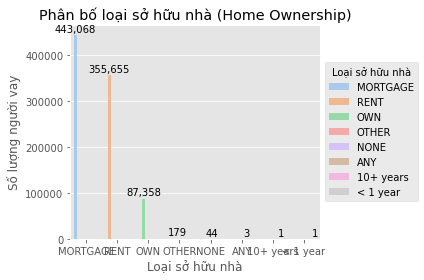

In [17]:
home_borrower_profile_df = borrower_profile_df.groupBy("home_ownership").count().orderBy("count", ascending=False)
home_pd = home_borrower_profile_df.toPandas()

plt.figure(figsize=(6,4))
ax = sns.barplot(
    x="home_ownership", 
    y="count", 
    hue="home_ownership",
    data=home_pd, 
    palette="pastel", 
)

for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + home_pd["count"].max() * 0.005,
            f"{int(height):,}",
            ha="center", va="bottom", fontsize=10
        )
ax.legend(
    title="Loại sở hữu nhà",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Phân bố loại sở hữu nhà (Home Ownership)")
plt.xlabel("Loại sở hữu nhà")
plt.ylabel("Số lượng người vay")
plt.tight_layout()
plt.show()

## Phân bố tình trạng xác minh thu nhập (Verification Status)

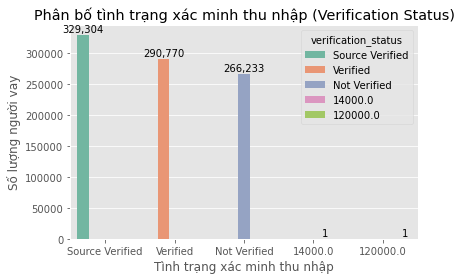

In [19]:
verif_pd = borrower_profile_df.groupBy("verification_status").count().orderBy(desc("count")).toPandas()

plt.figure(figsize=(6,4))
ax = sns.barplot(
    x="verification_status",
    y="count",
    hue="verification_status",
    data=verif_pd,
    palette="Set2",
)

for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + verif_pd["count"].max() * 0.005,
            f"{int(height):,}",
            ha="center", va="bottom", fontsize=10
        )
        
plt.title("Phân bố tình trạng xác minh thu nhập (Verification Status)")
plt.xlabel("Tình trạng xác minh thu nhập")
plt.ylabel("Số lượng người vay")
plt.tight_layout()
plt.show()

## Phân bố thời gian làm việc của người vay (Emp Length)

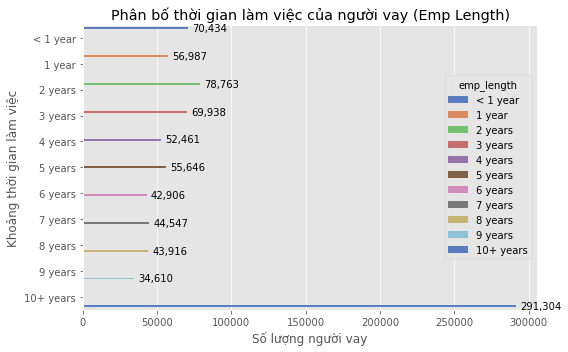

In [21]:
emp_pd = borrower_profile_df.groupBy("emp_length").count().toPandas()

order = [
    "< 1 year", "1 year", "2 years", "3 years", "4 years",
    "5 years", "6 years", "7 years", "8 years", "9 years", "10+ years"
]

emp_pd = emp_pd[emp_pd["emp_length"].isin(order)]
emp_pd["emp_length"] = pd.Categorical(emp_pd["emp_length"], categories=order, ordered=True)
emp_pd = emp_pd.sort_values("emp_length")

plt.figure(figsize=(8,5))
ax = sns.barplot(
    y="emp_length",
    x="count",
    hue="emp_length",
    data=emp_pd,
    palette="muted",
)

for p in ax.patches:
    width = p.get_width()
    if not np.isnan(width):
        ax.text(
            width + emp_pd["count"].max() * 0.01, 
            p.get_y() + p.get_height() / 2,
            f"{int(width):,}",                   
            va="center", ha="left", fontsize=10
        )

plt.title("Phân bố thời gian làm việc của người vay (Emp Length)")
plt.xlabel("Số lượng người vay")
plt.ylabel("Khoảng thời gian làm việc")
plt.tight_layout()
plt.show()


## Top 10 bang/khu vực có nhiều người vay nhất

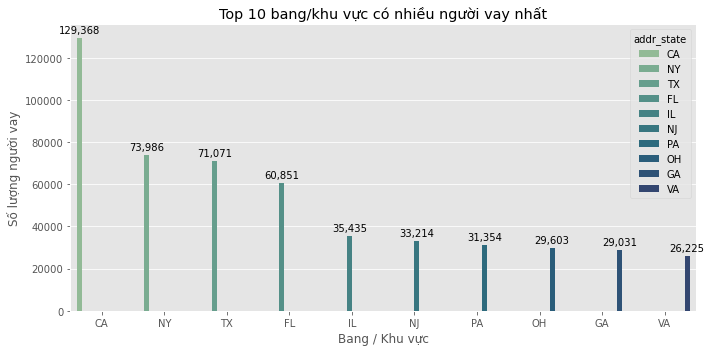

In [23]:
state_pd = (
    borrower_profile_df.groupBy("addr_state")
      .count()
      .orderBy(desc("count"))
      .limit(10)
      .toPandas()
)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x="addr_state",
    y="count",
    data=state_pd,
    hue="addr_state",
    palette="crest",
)

for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):  # bỏ qua nếu giá trị là NaN
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + state_pd["count"].max() * 0.01,
            f"{int(height):,}",
            ha="center", va="bottom", fontsize=10
        )

plt.title("Top 10 bang/khu vực có nhiều người vay nhất")
plt.xlabel("Bang / Khu vực")
plt.ylabel("Số lượng người vay")
plt.tight_layout()
plt.show()


In [24]:
spark.stop()

# 2. Loan_info: Thông tin khoản vay

In [25]:
from pyspark.sql.functions import *

In [26]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("EDA_LoanInfo") \
    .getOrCreate()

In [27]:
loan_df = spark.read.csv("hdfs://namenode:9000/bigdata/data/splitted_data/loan_info", header=True, inferSchema=True)
p_loan_df = loan_df.toPandas()
loan_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- policy_code: double (nullable = true)
 |-- application_type: string (nullable = true)



## Thống kê mô tả tổng quát

In [28]:
loan_df.describe(["loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "installment"]).show()

+-------+------------------+------------------+------------------+------------------+-----------------+
|summary|         loan_amnt|       funded_amnt|   funded_amnt_inv|          int_rate|      installment|
+-------+------------------+------------------+------------------+------------------+-----------------+
|  count|            886309|            886309|            886309|            886309|           886309|
|   mean|14758.921860209024|14745.669935654496|14707.464974100456|13.246282222113768|436.8088670881018|
| stddev| 8434.560405312674| 8429.020420875398| 8440.122486131671| 4.382057313669209|244.1522564673065|
|    min|             500.0|             500.0|               0.0|              5.32|            15.67|
|    max|           35000.0|           35000.0|           35000.0|             28.99|          1445.46|
+-------+------------------+------------------+------------------+------------------+-----------------+



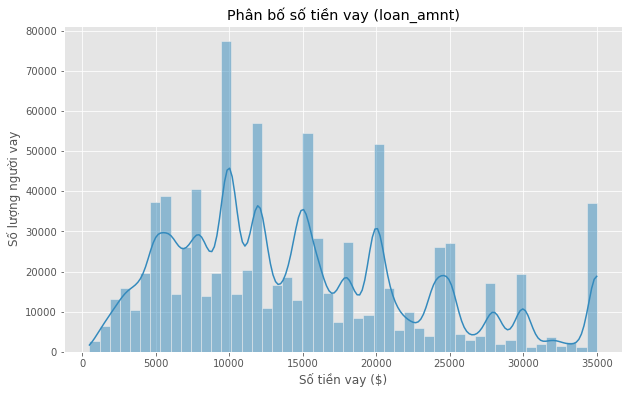

In [29]:
plt.figure(figsize=(10,6))
sns.histplot(p_loan_df["loan_amnt"], bins=50, kde=True)
plt.title("Phân bố số tiền vay (loan_amnt)")
plt.xlabel("Số tiền vay ($)")
plt.ylabel("Số lượng người vay")
plt.show()

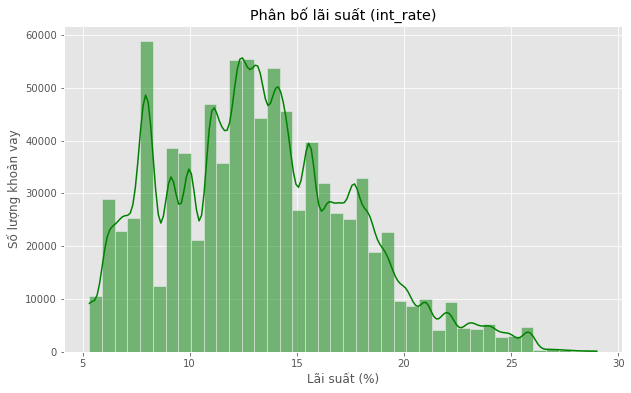

In [30]:
plt.figure(figsize=(10,6))
sns.histplot(p_loan_df["int_rate"], bins=40, kde=True, color="green")
plt.title("Phân bố lãi suất (int_rate)")
plt.xlabel("Lãi suất (%)")
plt.ylabel("Số lượng khoản vay")
plt.show()

## Tỷ lệ tài trợ thực tế (funded_amnt / loan_amnt)

+------------------+
| avg(funded_ratio)|
+------------------+
|0.9992938377209872|
+------------------+



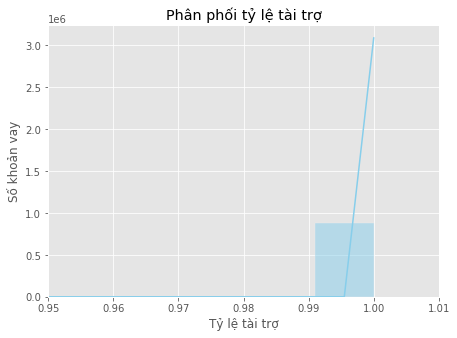

In [31]:
loan_df = loan_df.withColumn("funded_ratio", col("funded_amnt") / col("loan_amnt"))
loan_df.select(avg("funded_ratio")).show()
p_loan_df = loan_df.toPandas()

plt.figure(figsize=(7,5))
sns.histplot(p_loan_df["funded_ratio"], bins=100, kde=True, color="skyblue")
plt.xlim(0.95, 1.01)
plt.title("Phân phối tỷ lệ tài trợ")
plt.xlabel("Tỷ lệ tài trợ")
plt.ylabel("Số khoản vay")
plt.show()


## Thống kê theo thời hạn vay (term)

+---------+------+
|     term| count|
+---------+------+
|36 months|620250|
|60 months|266059|
+---------+------+



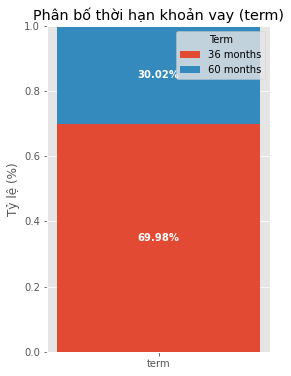

In [32]:
loan_df.groupBy("term").count().orderBy("count", ascending=False).show()
term_pd = loan_df.groupBy("term").count().toPandas()
total = term_pd["count"].sum()
term_pd["pct"] = term_pd["count"] / total
plt.figure(figsize=(4,6))

plt.bar(
    x=["term"], 
    height=term_pd.loc[term_pd["term"]=="36 months", "pct"], 
    label="36 months"
)
plt.bar(
    x=["term"], 
    height=term_pd.loc[term_pd["term"]=="60 months", "pct"], 
    bottom=term_pd.loc[term_pd["term"]=="36 months", "pct"], 
    label="60 months"
)

bottom = 0
for i, row in term_pd.iterrows():
    plt.text(
        0, 
        bottom + row["pct"]/2, 
        f"{row['pct']*100:.2f}%", 
        ha="center", 
        va="center", 
        color="white", 
        fontweight="bold"
    )
    bottom += row["pct"]

plt.ylabel("Tỷ lệ (%)")
plt.title("Phân bố thời hạn khoản vay (term)")
plt.legend(title="Term")
plt.ylim(0,1)
plt.show()

## Thống kê theo hạng tín dụng (grade)

+-----+------+
|grade| count|
+-----+------+
|    A|148059|
|    B|254267|
|    C|245603|
|    D|139338|
|    E| 70586|
|    F| 22992|
|    G|  5464|
+-----+------+



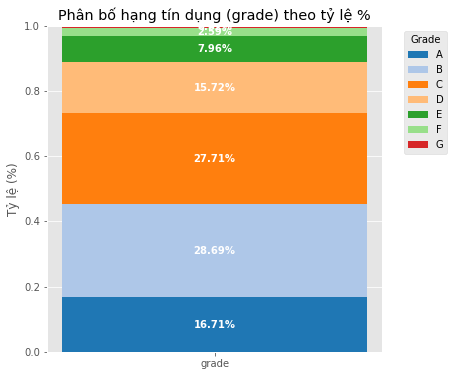

In [33]:
loan_df.groupBy("grade").count().orderBy("grade").show()
grade_pd = loan_df.groupBy("grade").count().orderBy("grade").toPandas()

# Tính phần trăm
total = grade_pd["count"].sum()
grade_pd["pct"] = grade_pd["count"] / total

# Vẽ stacked bar
plt.figure(figsize=(6,6))
bottom = 0
colors = plt.cm.tab20.colors  # Chọn bảng màu

for i, row in grade_pd.iterrows():
    plt.bar(
        x=["grade"], 
        height=row["pct"], 
        bottom=bottom, 
        label=row["grade"], 
        color=colors[i % len(colors)]
    )
    # Ghi % ở giữa từng phần
    plt.text(
        0, 
        bottom + row["pct"]/2, 
        f"{row['pct']*100:.2f}%", 
        ha="center", va="center", color="white", fontweight="bold"
    )
    bottom += row["pct"]

plt.title("Phân bố hạng tín dụng (grade) theo tỷ lệ %")
plt.ylim(0,1)
plt.ylabel("Tỷ lệ (%)")
plt.legend(title="Grade", bbox_to_anchor=(1.05, 1))
plt.show()

## Phân bố mục đích vay

In [34]:
loan_purpose = loan_df.groupBy("purpose").agg(
    count("*").alias("count"),
    avg("loan_amnt").alias("avg_loan"),
    avg("int_rate").alias("avg_interest")
).orderBy(col("count").desc())
loan_purpose.show(truncate=False)

+------------------+------+------------------+------------------+
|purpose           |count |avg_loan          |avg_interest      |
+------------------+------+------------------+------------------+
|debt_consolidation|523782|15430.202164259177|13.601132704062291|
|credit_card       |206013|15340.51807410212 |11.773687340119295|
|home_improvement  |51717 |14323.072684030396|13.024062300597503|
|other             |42745 |9897.075681366241 |15.025574687097976|
|major_purchase    |17234 |11609.172275734014|12.672851340373658|
|small_business    |10328 |15431.33714175058 |16.243629938032505|
|car               |8839  |8885.479126598031 |12.001082701663046|
|medical           |8514  |9020.689452666196 |14.556872210476806|
|moving            |5404  |7891.205588452998 |15.73107512953364 |
|vacation          |4723  |6289.8687275037055|14.337203048909567|
|house             |3699  |14805.751554474182|16.016366585563652|
|wedding           |2340  |10465.042735042734|14.15090598290595 |
|renewable

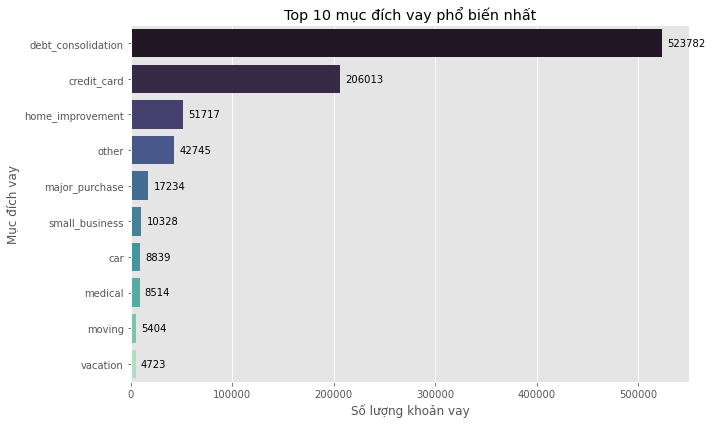

In [35]:
top10_purpose = p_loan_df["purpose"].value_counts().head(10).reset_index()
top10_purpose.columns = ["purpose", "count"]

plt.figure(figsize=(10, 6))
sns.barplot(
    y="purpose",
    x="count",
    hue="purpose",
    data=top10_purpose,
    palette="mako",
    dodge=False 
)
plt.legend([],[], frameon=False)

# Thêm số phía sau bar
for index, row in top10_purpose.iterrows():
    plt.text(
        row["count"] + 5000,
        index,
        str(row["count"]),
        va='center'
    )

plt.title("Top 10 mục đích vay phổ biến nhất")
plt.xlabel("Số lượng khoản vay")
plt.ylabel("Mục đích vay")
plt.tight_layout()
plt.show()

## Lãi suất trung bình theo hạng tín dụng

In [36]:
avg_rate_by_grade = loan_df.groupBy("grade").agg(avg("int_rate").alias("avg_interest")).orderBy("grade")
avg_rate_by_grade.show()

+-----+------------------+
|grade|      avg_interest|
+-----+------------------+
|    A| 7.242850147576409|
|    B|10.829743576633629|
|    C|13.980599422644682|
|    D|17.177087442047767|
|    E|19.900073243986363|
|    F|  23.5903527313851|
|    G|25.645948023426065|
+-----+------------------+



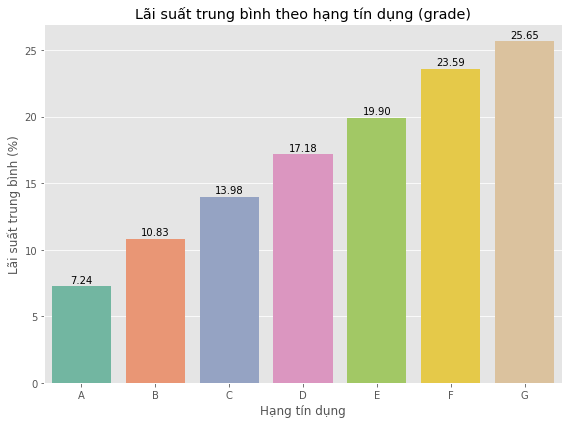

In [37]:
plt.figure(figsize=(8, 6))

mean_int_rate = p_loan_df.groupby("grade")["int_rate"].mean().reset_index()

sns.barplot(
    x="grade",
    y="int_rate",
    hue="grade",
    data=mean_int_rate,
    palette="Set2",
    dodge=False
)
plt.legend([],[], frameon=False)  # Tắt legend

# Thêm nhãn giá trị trên mỗi bar
for index, row in mean_int_rate.iterrows():
    plt.text(
        index,       
        row["int_rate"] + 0.1, 
        f"{row['int_rate']:.2f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title("Lãi suất trung bình theo hạng tín dụng (grade)")
plt.xlabel("Hạng tín dụng")
plt.ylabel("Lãi suất trung bình (%)")
plt.tight_layout()
plt.show()


## Lãi suất trung bình theo thời hạn vay

+---------+------------------+
|     term|      avg_interest|
+---------+------------------+
|36 months|12.017624264408472|
|60 months| 16.11059088397553|
+---------+------------------+



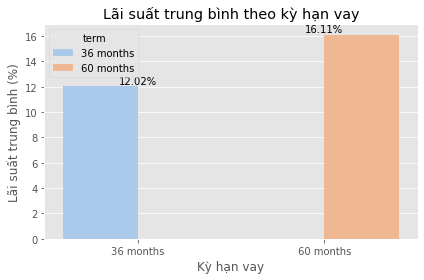

In [39]:
avg_rate_by_term = loan_df.groupBy("term").agg(avg("int_rate").alias("avg_interest")).orderBy("term")
avg_rate_by_term.show()
avg_rate_by_term = avg_rate_by_term.toPandas()

plt.figure(figsize=(6,4))
sns.barplot(
    x="term", 
    y="avg_interest", 
    hue="term",
    data=avg_rate_by_term, 
    palette="pastel",
)

plt.title("Lãi suất trung bình theo kỳ hạn vay")
plt.xlabel("Kỳ hạn vay")
plt.ylabel("Lãi suất trung bình (%)")

# Thêm giá trị trên mỗi cột
for index, row in avg_rate_by_term.iterrows():
    plt.text(index, row.avg_interest + 0.2, f"{row.avg_interest:.2f}%", ha='center')

plt.tight_layout()
plt.show()

In [40]:
spark.stop()

# 3. Loan status history: Lịch sử trạng thái khoản vay

In [41]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("LoanStatusAnalysis") \
    .getOrCreate()

In [42]:
path = "hdfs://namenode:9000/bigdata/data/splitted_data/loan_status_history"

loan_status_history_df = (
    spark.read
    .option("header", True)
    .schema(loan_status_history_schema)
    .csv(path)
)

loan_status_history_df.printSchema()
loan_status_history_df.show(5)


root
 |-- id: integer (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- last_pymnt_d: string (nullable = true)
 |-- next_pymnt_d: string (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- out_prncp: double (nullable = true)
 |-- out_prncp_inv: double (nullable = true)

+--------+-----------+----------+-------------------+------------+-----------------+---------------+---------+-------------+
|      id|loan_status|pymnt_plan|initial_list_status|last_pymnt_d|     next_pymnt_d|last_pymnt_amnt|out_prncp|out_prncp_inv|
+--------+-----------+----------+-------------------+------------+-----------------+---------------+---------+-------------+
|19055956|    Current|         n|                  f|    Jan-2016|         Feb-2016|         754.28| 11896.63|     11896.63|
|19426164| Fully Paid|         n|                  w|    Apr-2015|No future payment|        5527.73|  

## Thống kê trạng thái khoản vay

+--------------------+------+
|         loan_status| count|
+--------------------+------+
|             Current|601482|
|          Fully Paid|207306|
|         Charged Off| 45155|
|  Late (31-120 days)| 11581|
|              Issued|  8340|
|     In Grace Period|  6251|
|   Late (16-30 days)|  2355|
|Does not meet the...|  1894|
|             Default|  1218|
|Does not meet the...|   727|
+--------------------+------+



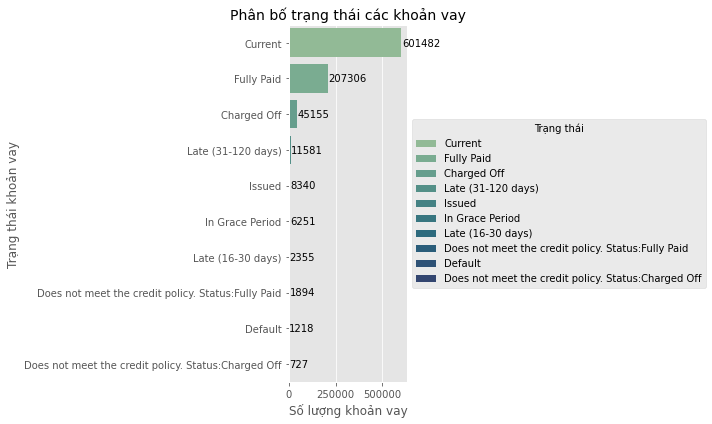

In [46]:
status_counts = (
    loan_status_history_df.groupBy("loan_status")
      .agg(count("*").alias("count"))
      .orderBy(col("count").desc())
)
status_counts.show()
status_counts_pd = status_counts.toPandas()

# Sắp xếp giảm dần theo số lượng
status_counts_pd = status_counts_pd.sort_values(by="count", ascending=False)

# Vẽ biểu đồ cột ngang
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    y="loan_status",
    x="count",
    hue="loan_status",
    data=status_counts_pd,
    palette="crest",
    dodge=False,
)

for index, row in status_counts_pd.iterrows():
    plt.text(
        row["count"] + 2000,
        index,
        str(row["count"]),
        va="center"
    )

ax.legend(
    title="Trạng thái",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.title("Phân bố trạng thái các khoản vay", fontsize=14)
plt.xlabel("Số lượng khoản vay")
plt.ylabel("Trạng thái khoản vay")
plt.tight_layout()
plt.show()

## Trung bình số dư gốc theo trạng thái

+--------------------+------------------+
|         loan_status|     avg_out_prncp|
+--------------------+------------------+
|              Issued|15289.389113908872|
|             Current|11761.248248925249|
|     In Grace Period| 11710.20442489202|
|  Late (31-120 days)|11691.441971332355|
|             Default|11601.024474548438|
|   Late (16-30 days)|11516.817779193208|
|          Fully Paid|               0.0|
|         Charged Off|               0.0|
|Does not meet the...|               0.0|
|Does not meet the...|               0.0|
+--------------------+------------------+



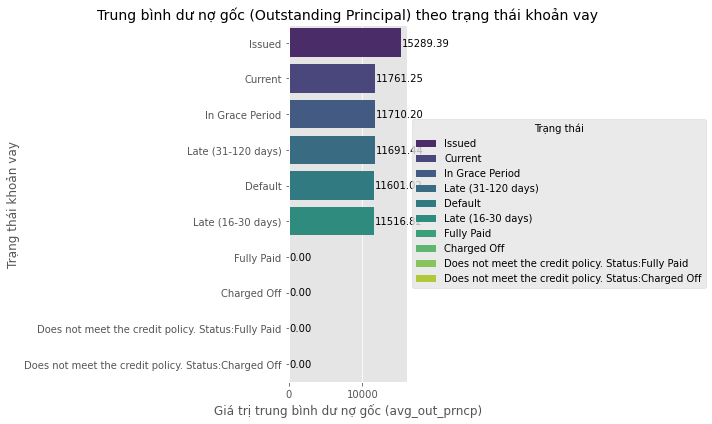

In [48]:
avg_out_prncp = (
    loan_status_history_df.groupBy("loan_status")
      .agg(avg("out_prncp").alias("avg_out_prncp"))
      .orderBy(col("avg_out_prncp").desc())
)
avg_out_prncp.show()
avg_out_prncp_pd = avg_out_prncp.toPandas()

# Sắp xếp giảm dần để hiển thị đẹp hơn
avg_out_prncp_pd = avg_out_prncp_pd.sort_values(by="avg_out_prncp", ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    y="loan_status",
    x="avg_out_prncp",
    hue="loan_status",   
    data=avg_out_prncp_pd,
    palette="viridis",
    dodge=False,
)

# Thêm nhãn giá trị trung bình bên cạnh mỗi thanh
for index, row in avg_out_prncp_pd.iterrows():
    plt.text(
        row["avg_out_prncp"] + 100,
        index,
        f"{row['avg_out_prncp']:.2f}",
        va="center"
    )
    
ax.legend(
    title="Trạng thái",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

# Tiêu đề và nhãn
plt.title("Trung bình dư nợ gốc (Outstanding Principal) theo trạng thái khoản vay", fontsize=14)
plt.xlabel("Giá trị trung bình dư nợ gốc (avg_out_prncp)")
plt.ylabel("Trạng thái khoản vay")
plt.tight_layout()
plt.show()

##  Kế hoạch trả góp (pymnt_plan)

+----------+------+
|pymnt_plan| count|
+----------+------+
|         n|886299|
|         y|    10|
+----------+------+



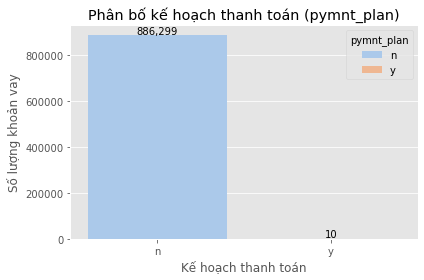

In [49]:
plan_counts = loan_status_history_df.groupBy("pymnt_plan").agg(count("*").alias("count"))
plan_counts.show()
plan_pd = plan_counts.toPandas()

# Vẽ biểu đồ
plt.figure(figsize=(6,4))
sns.barplot(
    x="pymnt_plan",
    y="count",
    hue="pymnt_plan",   # tránh FutureWarning
    data=plan_pd,
    palette="pastel",
    dodge=False,
)

# Thêm nhãn số trên mỗi thanh
for index, row in plan_pd.iterrows():
    plt.text(
        x=index,
        y=row["count"] + 5000,  # nâng nhãn lên trên thanh
        s=f"{row['count']:,}",
        ha="center"
    )

# Thêm tiêu đề và nhãn trục
plt.title("Phân bố kế hoạch thanh toán (pymnt_plan)")
plt.xlabel("Kế hoạch thanh toán")
plt.ylabel("Số lượng khoản vay")
plt.tight_layout()
plt.show()

## Trung bình gốc còn lại theo kế hoạch trả góp

+----------+-----------------------+
|pymnt_plan|avg_remaining_principal|
+----------+-----------------------+
|         n|      8407.364215970076|
|         y|              10535.823|
+----------+-----------------------+



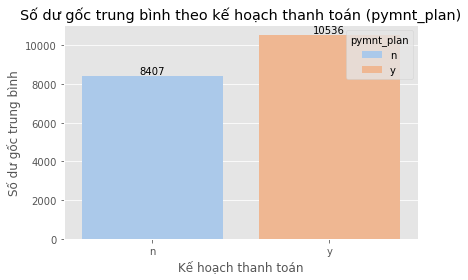

In [51]:
avg_principal_plan = (
    loan_status_history_df.groupBy("pymnt_plan")
      .agg(avg("out_prncp").alias("avg_remaining_principal"))
)
avg_principal_plan.show()
avg_principal_pd = avg_principal_plan.toPandas()

plt.figure(figsize=(6,4))
sns.barplot(
    x="pymnt_plan",
    y="avg_remaining_principal",
    hue="pymnt_plan",
    data=avg_principal_pd,
    palette="pastel",
    dodge=False,
)

for index, row in avg_principal_pd.iterrows():
    plt.text(
        x=index,
        y=row["avg_remaining_principal"] + 100,
        s=f"{row['avg_remaining_principal']:.0f}",
        ha="center"
    )

plt.title("Số dư gốc trung bình theo kế hoạch thanh toán (pymnt_plan)")
plt.xlabel("Kế hoạch thanh toán")
plt.ylabel("Số dư gốc trung bình")
plt.tight_layout()
plt.show()

In [52]:
spark.stop()

# 4. Repayment_summary: Tổng hợp trả nợ vay

In [53]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("RepaymentSummaryAnalysis") \
    .getOrCreate()

In [54]:
repayment_summary_df = spark.read.csv(
    "hdfs://namenode:9000/bigdata/data/splitted_data/repayment_summary",
    header=True,
    schema=repayment_summary_schema
)

In [55]:
repayment_summary_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_pymnt_inv: double (nullable = true)
 |-- total_rec_prncp: double (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- total_rec_late_fee: double (nullable = true)
 |-- recoveries: double (nullable = true)
 |-- collection_recovery_fee: double (nullable = true)



In [56]:
repayment_summary_df = repayment_summary_df.withColumn("principal_ratio", col("total_rec_prncp") / col("total_pymnt")) \
       .withColumn("interest_ratio", col("total_rec_int") / col("total_pymnt")) \
       .withColumn("recovery_ratio", (col("recoveries") + col("collection_recovery_fee")) / col("total_pymnt"))

## Thống kê tổng quát

In [57]:
summary_stats = repayment_summary_df.selectExpr(
    "avg(total_pymnt) as avg_total_pymnt",
    "avg(total_rec_prncp) as avg_principal",
    "avg(total_rec_int) as avg_interest",
    "avg(total_rec_late_fee) as avg_late_fee",
    "avg(recoveries) as avg_recoveries"
).withColumn("avg_total_revenue", col("avg_principal") + col("avg_interest") + col("avg_late_fee") + col("avg_recoveries"))

summary_stats.show(truncate=False)

+----------------+------------------+------------------+------------------+-----------------+-----------------+
|avg_total_pymnt |avg_principal     |avg_interest      |avg_late_fee      |avg_recoveries   |avg_total_revenue|
+----------------+------------------+------------------+------------------+-----------------+-----------------+
|7559.02311596743|5757.5767497114575|1755.1679467206138|0.3948967797912467|45.88352342128983|7559.023116633153|
+----------------+------------------+------------------+------------------+-----------------+-----------------+



In [58]:
avg_ratios = repayment_summary_df.select(
    avg("principal_ratio").alias("avg_principal_ratio"),
    avg("interest_ratio").alias("avg_interest_ratio"),
    avg("recovery_ratio").alias("avg_recovery_ratio")
)
print("\n📈 TỶ LỆ TRUNG BÌNH (%):")
avg_ratios.show()


📈 TỶ LỆ TRUNG BÌNH (%):
+-------------------+------------------+--------------------+
|avg_principal_ratio|avg_interest_ratio|  avg_recovery_ratio|
+-------------------+------------------+--------------------+
| 0.7147359389844867|0.2774501123261703|0.008445218058093684|
+-------------------+------------------+--------------------+



In [60]:
p_repayment_summary_df = repayment_summary_df.select(
    "total_pymnt", "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "recoveries", "collection_recovery_fee",
    "principal_ratio", "interest_ratio", "recovery_ratio"
).toPandas()

cols_to_float = [
    "total_pymnt", "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "recoveries", "collection_recovery_fee",
    "principal_ratio", "interest_ratio", "recovery_ratio"
]

for c in cols_to_float:
    p_repayment_summary_df[c] = pd.to_numeric(p_repayment_summary_df[c], errors="coerce")

p_repayment_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886309 entries, 0 to 886308
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   total_pymnt              886309 non-null  float64
 1   total_rec_prncp          886309 non-null  float64
 2   total_rec_int            886309 non-null  float64
 3   total_rec_late_fee       886309 non-null  float64
 4   recoveries               886309 non-null  float64
 5   collection_recovery_fee  886309 non-null  float64
 6   principal_ratio          868685 non-null  float64
 7   interest_ratio           868685 non-null  float64
 8   recovery_ratio           868685 non-null  float64
dtypes: float64(9)
memory usage: 60.9 MB


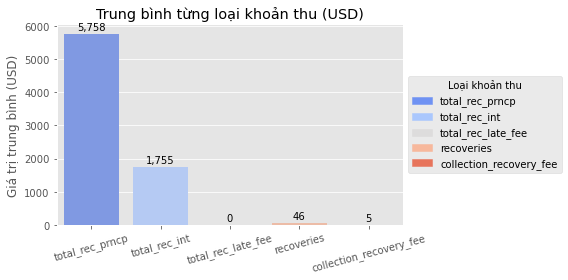

In [64]:
avg_vals = p_repayment_summary_df[
    ["total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee"]
].mean()

plt.figure(figsize=(8,4))
ax = sns.barplot(
    x=avg_vals.index,
    y=avg_vals.values,
    palette="coolwarm"
)

for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width()/2,
            height + avg_vals.max() * 0.01,     
            f"{height:,.0f}",              
            ha="center", va="bottom", fontsize=10
        )

handles = [
    plt.Rectangle((0,0), 1, 1, color=color)
    for color in sns.color_palette("coolwarm", n_colors=len(avg_vals))
]
ax.legend(
    handles=handles,
    labels=list(avg_vals.index),
    title="Loại khoản thu",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.title("Trung bình từng loại khoản thu (USD)")
plt.ylabel("Giá trị trung bình (USD)")
plt.xlabel("")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

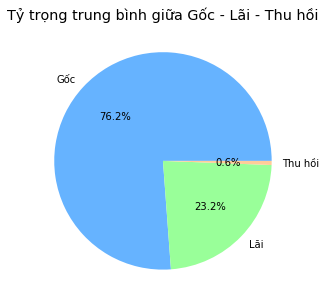

In [66]:
# Biểu đồ tròn — tỷ trọng trung bình của các khoản thu
plt.figure(figsize=(5,5))
plt.pie(
    [avg_vals["total_rec_prncp"], avg_vals["total_rec_int"], avg_vals["recoveries"]],
    labels=["Gốc", "Lãi", "Thu hồi"],
    autopct="%1.1f%%", colors=["#66b3ff", "#99ff99", "#ffcc99"]
)
plt.title("Tỷ trọng trung bình giữa Gốc - Lãi - Thu hồi")
plt.show()

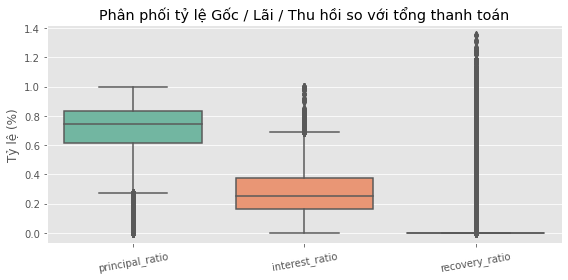

In [67]:
# Boxplot — so sánh tỷ lệ gốc/lãi/thu hồi trên tổng thanh toán
plt.figure(figsize=(8,4))
sns.boxplot(data=p_repayment_summary_df[["principal_ratio", "interest_ratio", "recovery_ratio"]], palette="Set2")
plt.title("Phân phối tỷ lệ Gốc / Lãi / Thu hồi so với tổng thanh toán")
plt.ylabel("Tỷ lệ (%)")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()


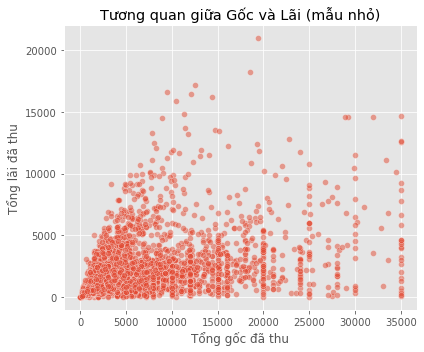

In [69]:
# Scatter — kiểm tra tương quan gốc và lãi (lấy mẫu nhẹ)
sample_p_repayment_summary_df = p_repayment_summary_df.sample(n=__builtins__.min(4000, len(p_repayment_summary_df)), random_state=42)

plt.figure(figsize=(6,5))
sns.scatterplot(x="total_rec_prncp", y="total_rec_int", data=sample_p_repayment_summary_df, alpha=0.5)
plt.title("Tương quan giữa Gốc và Lãi (mẫu nhỏ)")
plt.xlabel("Tổng gốc đã thu")
plt.ylabel("Tổng lãi đã thu")
plt.tight_layout()
plt.show()

In [70]:
spark.stop()

## 5. Credit profile

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, datediff, current_date, to_date, regexp_replace

In [ ]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("CreditProfileAnalysis")
    .getOrCreate()

In [ ]:
df = spark.read.csv(
    "/home/jovyan/output_tables/credit_profile", 
    header=True, 
    schema=credit_profile_schema
)
df.printSchema()

In [ ]:
# Tiền xử lý
# Chuyển đổi ngày
df = df.withColumn("earliest_cr_line", to_date(col("earliest_cr_line"), "MMM-yyyy"))

# Thêm tuổi tín dụng (credit_age_months)
df = df.withColumn(
    "credit_age_months",
    datediff(current_date(), col("earliest_cr_line")) / 30
)


In [ ]:
# Tính các thống kê tổng quát
summary = df.select(
    F.avg("delinq_2yrs").alias("avg_delinq_2yrs"),
    F.avg("inq_last_6mths").alias("avg_inquiries_6mths"),
    F.avg("open_acc").alias("avg_open_acc"),
    F.avg("total_acc").alias("avg_total_acc"),
    F.avg("revol_bal").alias("avg_revol_bal"),
    F.avg("revol_util").alias("avg_revol_util"),
    F.avg("collections_12_mths_ex_med").alias("avg_collections_12m"),
    F.avg("credit_age_months").alias("avg_credit_age_months")
)
print("\n📊 Thống kê tổng quát hồ sơ tín dụng:")
summary.show(truncate=False)

In [ ]:
# Lưu ra Pandas để vẽ biểu đồ
pdf = df.sample(fraction=0.05, seed=42).toPandas()
print("\n✅ Số dòng mẫu để vẽ:", len(pdf))

In [ ]:
plt.figure(figsize=(7,4))

# Chuyển về numeric, làm sạch dữ liệu
pdf["revol_util"] = pd.to_numeric(pdf["revol_util"].astype(str).str.replace("%","",regex=False), errors="coerce")
pdf = pdf.dropna(subset=["revol_util"])

# Chia thành các khoảng 10%
bins = [0,10,20,30,40,50,60,70,80,90,100,200]
labels = [f"{i}-{i+10}%" for i in range(0,100,10)] + [">100%"]
pdf["revol_util_bin"] = pd.cut(pdf["revol_util"], bins=bins, labels=labels, include_lowest=True)

# Tạo bảng đếm thủ công rồi truyền cho Seaborn
freq = pdf["revol_util_bin"].value_counts().sort_index().reset_index()
freq.columns = ["revol_util_bin", "count"]

sns.barplot(data=freq, x="revol_util_bin", y="count", color="skyblue")

plt.title("📊 Tần suất theo khoảng tỷ lệ sử dụng tín dụng quay vòng")
plt.xlabel("Khoảng tỷ lệ sử dụng (%)")
plt.ylabel("Số lượng khách hàng")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Chuyển cột open_acc sang kiểu số, lỗi sẽ bị đổi thành NaN
pdf["open_acc"] = pd.to_numeric(pdf["open_acc"], errors="coerce")

# Sau đó chia nhóm
bins = [0, 5, 10, 15, 20, 25, 50]
labels = ["1–5", "6–10", "11–15", "16–20", "21–25", ">25"]
pdf["open_acc_group"] = pd.cut(pdf["open_acc"], bins=bins, labels=labels, include_lowest=True)

# Tính trung bình theo nhóm
avg_util_group = (
    pdf.groupby("open_acc_group")["revol_util"]
       .mean()
       .reset_index()
)

# Vẽ biểu đồ
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=avg_util_group, x="open_acc_group", y="revol_util", color="skyblue")
plt.title("Tỷ lệ sử dụng tín dụng trung bình theo số tài khoản mở")
plt.xlabel("Số tài khoản mở (nhóm)")
plt.ylabel("Tỷ lệ sử dụng trung bình (%)")
plt.tight_layout()
plt.show()

In [ ]:
spark.stop()

## 6.Credit account detail

In [ ]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("CreditAccountAnalysis") \
    .getOrCreate()

In [ ]:
# Đọc dữ liệu
df = spark.read.csv("/home/jovyan/output_tables/credit_account_detail", 
                           header=True, inferSchema=True)

print("📂 Credit Account Detail schema:")
df.printSchema()

In [ ]:
# Thống kê mô tả (mean, std, min, max)
print("\n=== Thống kê mô tả ===")
df.describe().show()

In [ ]:
#  Số lượng giá trị duy nhất cho ID
print("\n=== Số lượng giá trị unique cho ID và member_id ===")
df.select(
    countDistinct("id").alias("unique_id"),
    countDistinct("member_id").alias("unique_member")
).show()


In [ ]:

# Trung bình dư nợ và tỷ lệ sử dụng
df.select(
    avg("total_bal_il").alias("avg_total_bal_il"),
    avg("tot_cur_bal").alias("avg_tot_cur_bal"),
    avg("all_util").alias("avg_all_util"),
    avg("il_util").alias("avg_il_util"),
).show()

In [ ]:
# Trung bình số tài khoản mở theo thời gian
df.select(
    avg("open_acc_6m").alias("avg_open_6m"),
    avg("open_il_12m").alias("avg_open_12m"),
    avg("open_il_24m").alias("avg_open_24m"),
).show()

In [ ]:
# Chuyển toàn bộ sang pandas để plot
pdf = df.toPandas()

plt.figure(figsize=(15, 12))

In [ ]:
# Biểu đồ 1 — Phân phối tỷ lệ sử dụng tín dụng
plt.subplot(2, 2, 1)
sns.histplot(pdf["all_util"].dropna(), bins=30, color="skyblue", kde=True)
plt.title("Phân phối tỷ lệ sử dụng tổng hợp (all_util)")
plt.xlabel("Tỷ lệ sử dụng (%)")


In [ ]:
# Biểu đồ 2 — Quan hệ giữa giới hạn tín dụng và tỷ lệ sử dụng
plt.subplot(2, 2, 2)
sns.scatterplot(x="total_rev_hi_lim", y="all_util", data=pdf, alpha=0.5)
plt.title("Quan hệ giữa giới hạn tín dụng và tỷ lệ sử dụng")
plt.xlabel("Giới hạn tín dụng")
plt.ylabel("Tỷ lệ sử dụng (%)")

In [ ]:
# Biểu đồ 3 — Trung bình tỷ lệ sử dụng theo số tài khoản mở 12 tháng
plt.subplot(2, 2, 3)
avg_by_open = pdf.groupby("open_il_12m")["all_util"].mean().reset_index()
sns.barplot(x="open_il_12m", y="all_util", data=avg_by_open, color="lightgreen")
plt.title("Tỷ lệ sử dụng trung bình theo số tài khoản mở 12 tháng")
plt.xlabel("Số tài khoản mở (12 tháng)")
plt.ylabel("Tỷ lệ sử dụng trung bình (%)")

In [ ]:
# Biểu đồ 4 — Dư nợ vay cá nhân vs tổng dư nợ hiện tại
plt.subplot(2, 2, 4)
sns.scatterplot(x="total_bal_il", y="tot_cur_bal", data=pdf, alpha=0.5, color="coral")
plt.title("Quan hệ giữa dư nợ vay cá nhân và tổng dư nợ hiện tại")
plt.xlabel("Dư nợ vay cá nhân (total_bal_il)")
plt.ylabel("Tổng dư nợ hiện tại (tot_cur_bal)")


In [ ]:
spark.stop()